## Regression between the wind influence and SST

In [107]:
# Import necessary packages
import math
import copy

import xarray as xr
import pandas as pd
import numpy as np

import cartopy.crs as ccrs
import statsmodels.api as sm
import statsmodels.tsa.tsatools
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression as linr

import sys
sys.path.append('/Users/iriskeizer/Documents/Wind effect/Thesis-KNMI/SST/code')

import figures as fig
import regression as regr

#### Import and process the wind data

In [2]:
wind_data = pd.read_csv('/Users/iriskeizer/Documents/Wind effect/Data/observations/WindInfluenceSeaLevelDutchCoast.csv', index_col = 'time')


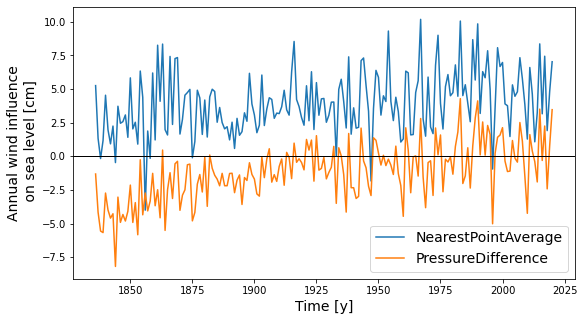

In [3]:
wind_data.plot(figsize = (9,5))
plt.legend(fontsize = 14)
plt.xlabel('Time [y]', fontsize = 14)
plt.ylabel('Annual wind influence\n on sea level [cm]', fontsize = 14)
plt.axhline(color='k', linewidth = 1)  


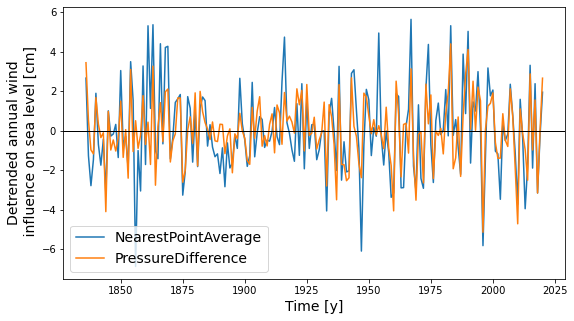

In [4]:
# Detrend the data using a third order polynomial
wind_data_dt = statsmodels.tsa.tsatools.detrend(wind_data, order=3, axis = 0)

wind_data_dt.plot(figsize = (9,5))
plt.legend(fontsize = 14)
plt.xlabel('Time [y]', fontsize = 14)
plt.ylabel('Detrended annual wind\n influence on sea level [cm]', fontsize = 14)
plt.axhline(color='k', linewidth = 1)  

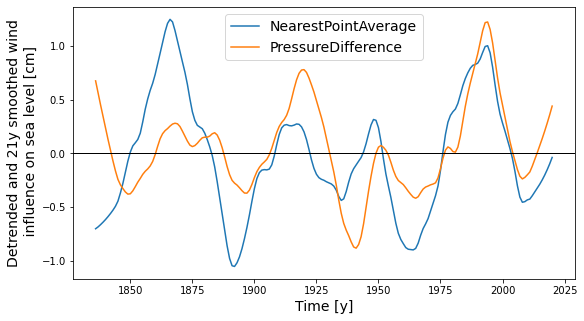

In [5]:
# Apply a LOWESS function with a 21-year smoothing window

def df_smooth(df, window):
    
    lowess = sm.nonparametric.lowess
    
    df_lo = df.copy()
    
    frac = window/(df.index.size)
    
    for column in df:
        df_lo[column] = lowess(df[column].values, df.index.values, frac, return_sorted=False)
        
        
    return df_lo


wind_data_dt_sm = df_smooth(wind_data_dt, 21)

wind_data_dt_sm.plot(figsize = (9,5))
plt.legend(fontsize = 14)
plt.xlabel('Time [y]', fontsize = 14)
plt.ylabel('Detrended and 21y smoothed wind\n influence on sea level [cm]', fontsize = 14)
plt.axhline(color='k', linewidth = 1)  

#### Import and process the SST data

In [52]:
# Import data

hadisst = xr.open_dataset('/Users/iriskeizer/Documents/Wind effect/Data/observations/SST/hadisst_processed.nc')
cobesst = xr.open_dataset('/Users/iriskeizer/Documents/Wind effect/Data/observations/SST/cobesst_processed.nc')


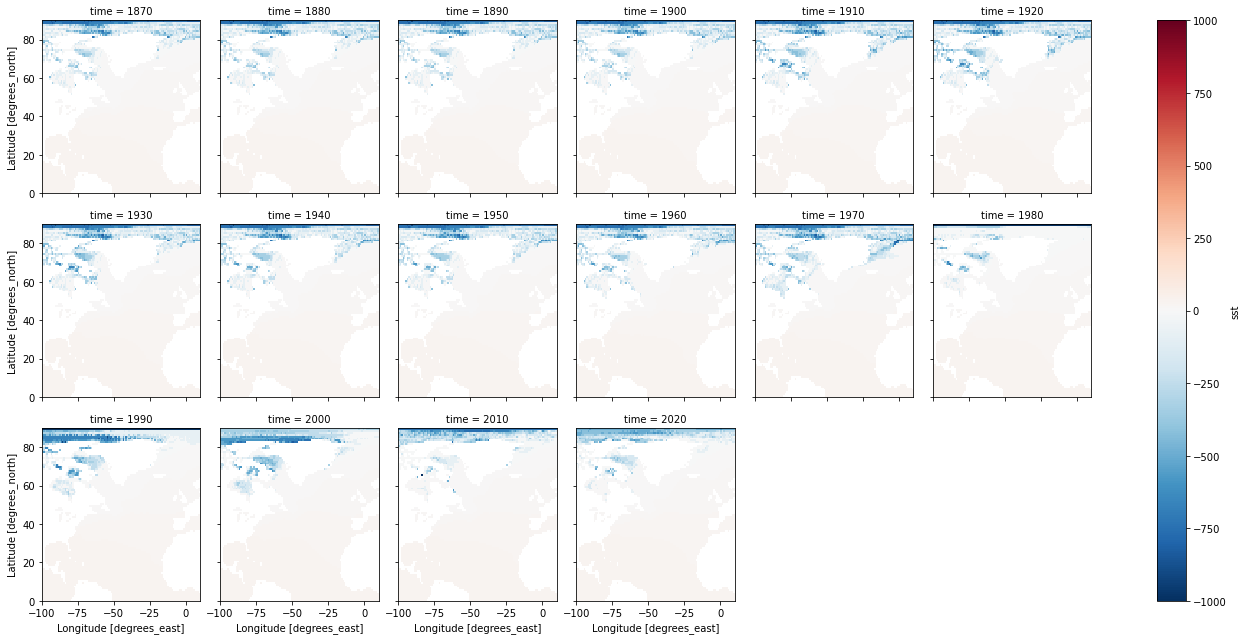

In [53]:
years = range(1860, 2022, 10)
hadisst.sst.where(hadisst.time.isin(years), drop = True).plot(col = 'time', col_wrap = 6)

Values of -1000°C are weird, these must be anomalies

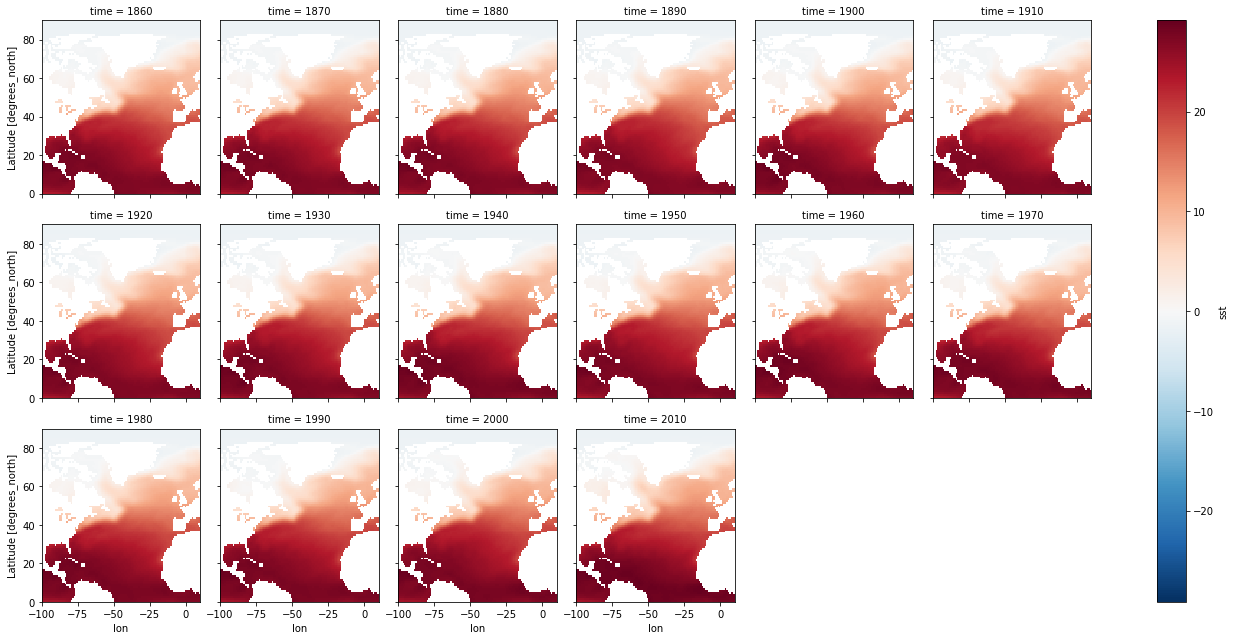

In [54]:
cobesst.sst.where(cobesst.time.isin(years), drop = True).plot(col = 'time', col_wrap = 6)

In [55]:
# Detrend the data using a third order polynomial
hadisst_dt = hadisst.sst - xr.polyval(hadisst.time, hadisst.sst.polyfit(dim = 'time', deg = 3).polyfit_coefficients)
cobesst_dt = cobesst.sst - xr.polyval(cobesst.time, cobesst.sst.polyfit(dim = 'time', deg = 3).polyfit_coefficients)




# Apply a LOWESS function with a 21-year smoothing window

def da_smooth(da, window):
    '''
    Function to smooth a dataarray
    
    '''
    lowess = sm.nonparametric.lowess
    
    years = da.time.values
    frac = frac = window / da.time.size
    
    def lowess_1d(data):
        return lowess(data, years, frac, return_sorted = False)
    
    
    da_low = xr.apply_ufunc(lowess_1d, da, input_core_dims = [['time']], output_core_dims = [['time']], vectorize = True)
    
    return da_low

hadisst_dt_sm = da_smooth(hadisst_dt, 21)
cobesst_dt_sm = da_smooth(cobesst_dt, 21)

/Users/iriskeizer/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/iriskeizer/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


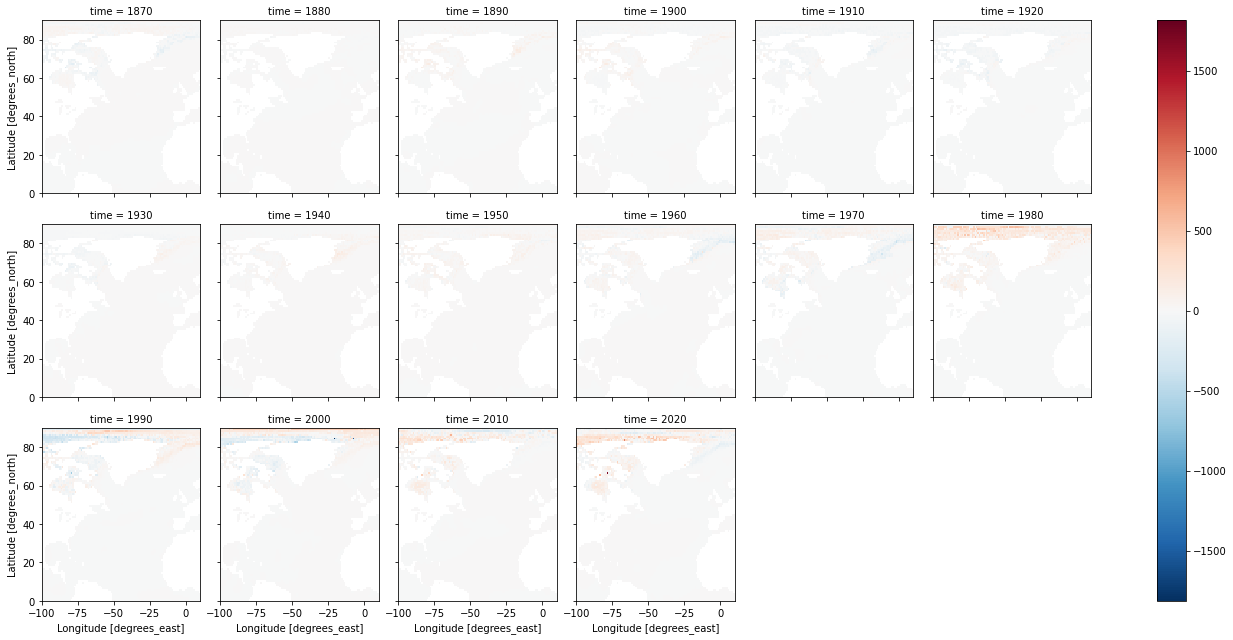

In [56]:
hadisst_dt_sm.where(hadisst_dt_sm.time.isin(years), drop = True).plot(col = 'time', col_wrap = 6)

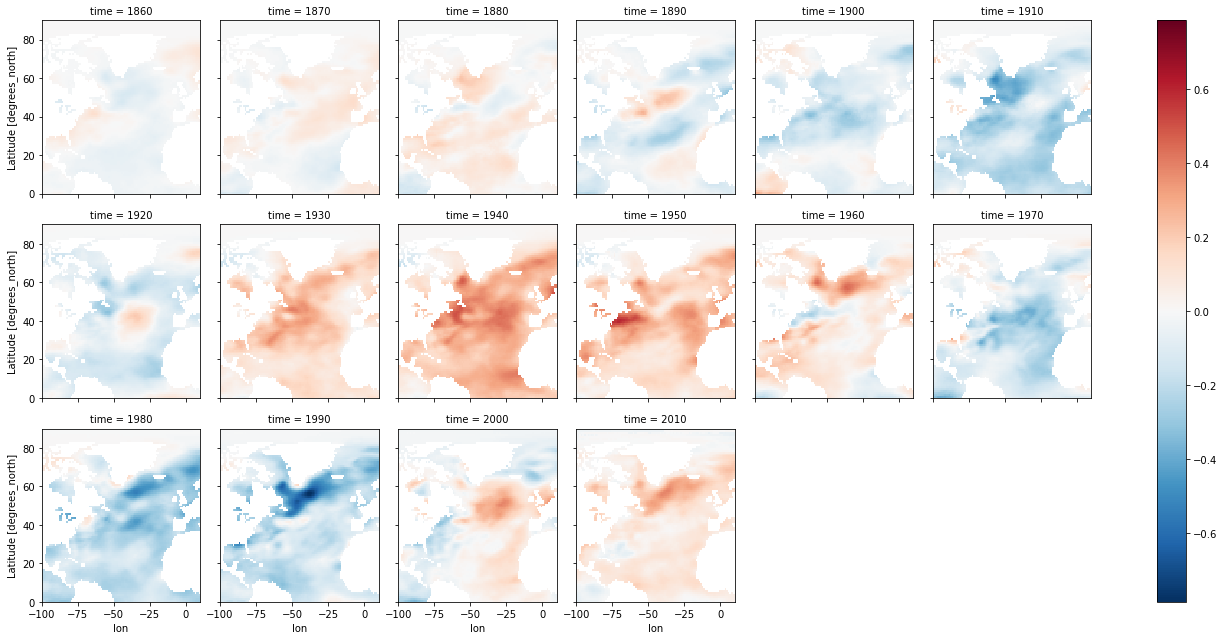

In [58]:
cobesst_dt_sm.where(cobesst_dt_sm.time.isin(years), drop = True).plot(col = 'time', col_wrap = 6)

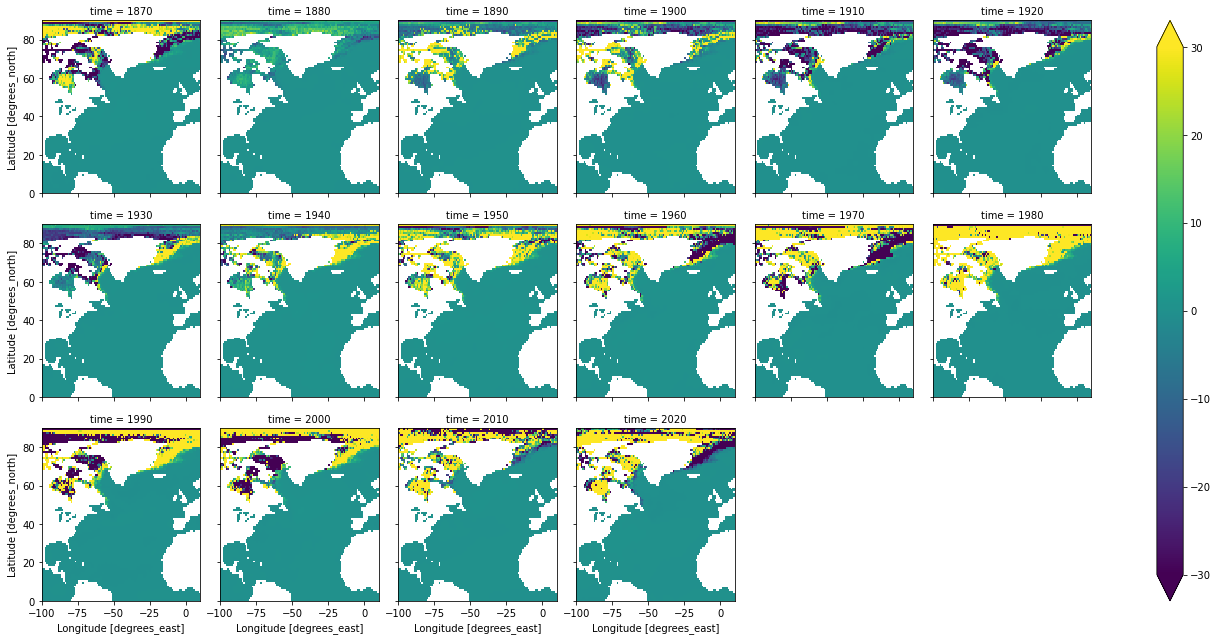

In [59]:
hadisst_dt_sm.where(hadisst_dt_sm.time.isin(years), drop = True).plot(col = 'time', col_wrap = 6, vmin = -30, vmax = 30)

These maps look terrible, something must be going wrong

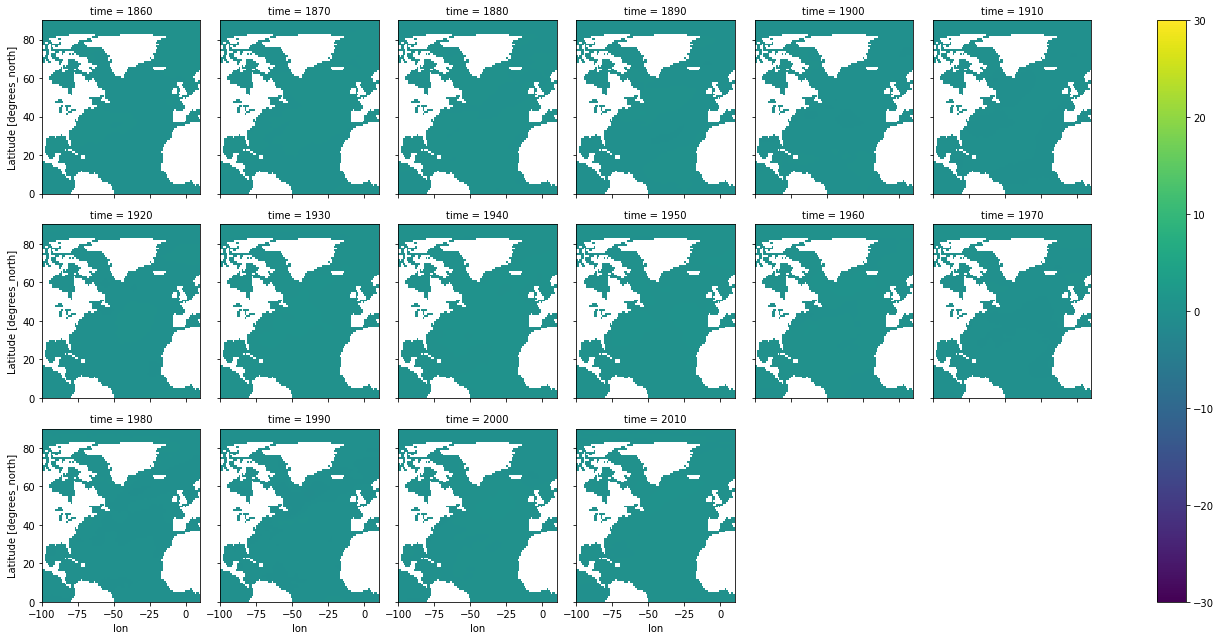

In [60]:
cobesst_dt_sm.where(cobesst_dt_sm.time.isin(years), drop = True).plot(col = 'time', col_wrap = 6, vmin = -30, vmax = 30)

Text(0, 0.5, 'SST [°C]')

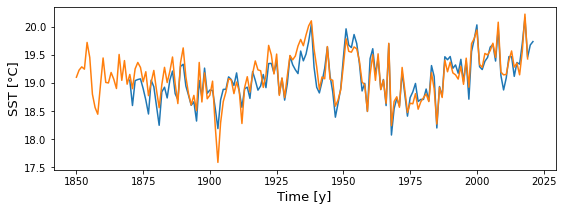

In [61]:
plt.figure(figsize=(9,3))
plt.plot(hadisst.time.values, hadisst.sel(lat = 40, lon = -40, method='Nearest').sst.values)
plt.plot(cobesst.time.values, cobesst.sel(lat = 40, lon = -40, method='Nearest').sst.values)
plt.xlabel('Time [y]', fontsize = 13)
plt.ylabel('SST [°C]', fontsize = 13)

Text(0, 0.5, 'Detrended SST [°C]')

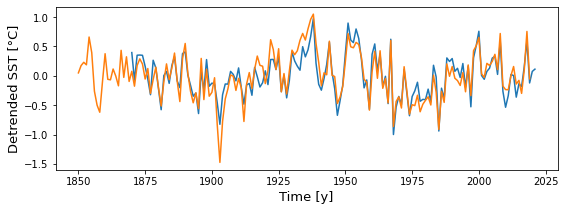

In [63]:
plt.figure(figsize=(9,3))
plt.plot(hadisst_dt.time.values, hadisst_dt.sel(lat = 40, lon = -40, method='Nearest').values)
plt.plot(cobesst_dt.time.values, cobesst_dt.sel(lat = 40, lon = -40, method='Nearest').values)
plt.xlabel('Time [y]', fontsize = 13)
plt.ylabel('Detrended SST [°C]', fontsize = 13)

Text(0, 0.5, 'Detrended and\n smoothed SST [°C]')

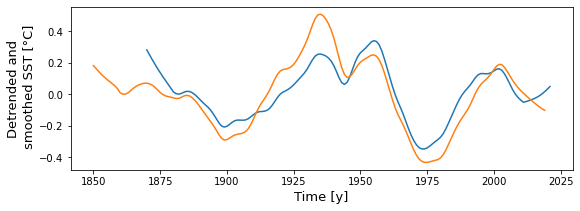

In [65]:
plt.figure(figsize=(9,3))
plt.plot(hadisst_dt_sm.time.values, hadisst_dt_s.sel(lat = 40, lon = -40, method='Nearest').values)
plt.plot(cobesst_dt_sm.time.values, cobesst_dt_s.sel(lat = 40, lon = -40, method='Nearest').values)
plt.xlabel('Time [y]', fontsize = 13)
plt.ylabel('Detrended and\n smoothed SST [°C]', fontsize = 13)

#### Perform regression

In [99]:
def regression(data_x, data_y):
    '''
    Data_x is sst and data_y is wind influence
    '''
    
    # Create dataframe
    x_l = pd.DataFrame(data={'time': data_x.time.values, 'SST':data_x.values})
    x_l = x_l.set_index('time')
    x_l = x_l.dropna()
    
    if x_l['SST'].size == 0:
        return [np.nan, np.nan, np.nan, np.nan], xr.DataArray(data=data_x.values ,dims=["time"], coords=dict(time=data_x.time.values,),) 
    
    
    # Standardize x
    scaler = StandardScaler()
    x_l = copy.deepcopy(x_l)
    x_l.iloc[:,:] = scaler.fit_transform(x_l)
    
    
    
    # Create data series of equal time span
    y = data_y[data_y.index.isin(x_l.index)]
    x = x_l[x_l.index.isin(y.index)]
    
    
    # Fit the regression model
    linear_regression = linr()
    fit = linear_regression.fit(x, y)
    r2 = linear_regression.score(x, y)
    intercept = linear_regression.intercept_
    coefs = linear_regression.coef_.tolist()[0]
    timeseries = coefs*x_l['SST']
    SST_reg_timeseries = xr.DataArray(data=timeseries.values ,dims=["time"], coords=dict(time=timeseries.index.values,),) 
        
    
    yhat = linear_regression.predict(x)
    mse = mean_squared_error(y, yhat) # Calculate insample mse (non-negative)
    rmse = np.sqrt(mse)
        
    
    
    return [rmse, r2, intercept, coefs], SST_reg_timeseries




def sst_regression(data_sst, data_wind):
    '''
    Function to perform the regression between the wind influence products and a SST product
    
    '''
    
    wind_labels = ['NearestPointAverage', 'PressureDifference']
    
    ts_lst_wind = []
    res_lst_wind = []
    for wl in wind_labels:
      
        ts_lst_lat = []
        res_lst_lat = []
        for lat in data_sst.lat:
            
            ts_lst_lon = []
            rmse_lst = []
            r2_lst = []
            intercept_lst = []
            coefs_lst = []
            for lon in data_sst.lon:
                
                result, ts = regression(data_sst.sel(lat=lat, lon=lon, drop = True), data_wind[wl])
                
                ts_lst_lon.append(ts)
                rmse_lst.append(result[0])
                r2_lst.append(result[1])
                intercept_lst.append(result[2])
                coefs_lst.append(result[3])
            
            
            ts_lst_lat.append(xr.concat(ts_lst_lon, dim=data_sst.lon))
            res_lst_lat.append(xr.Dataset(data_vars = dict(
                rmse = (['lon'], rmse_lst),
                r2 = (['lon'], r2_lst),
                intercept = (['lon'], intercept_lst),
                reg_coef = (['lon'], coefs_lst)),
                                             coords = dict(lon=data_sst.lon)))
            
        ts_lst_wind.append(xr.concat(ts_lst_lat, dim=data_sst.lat))
        res_lst_wind.append(xr.concat(res_lst_lat, dim=data_sst.lat))  
        
    timeseries = xr.concat(ts_lst_wind, dim=wind_labels).rename({"concat_dim":"wind_model"})
    results = xr.concat(res_lst_wind, dim=wind_labels).rename({"concat_dim":"wind_model"})
    
    
    return results, timeseries

In [103]:
results_hadisst, timeseries_hadisst = sst_regression(hadisst_dt_sm, wind_data_dt_sm)

In [106]:
results_cobesst, timeseries_cobesst = sst_regression(cobesst_dt_sm, wind_data_dt_sm)

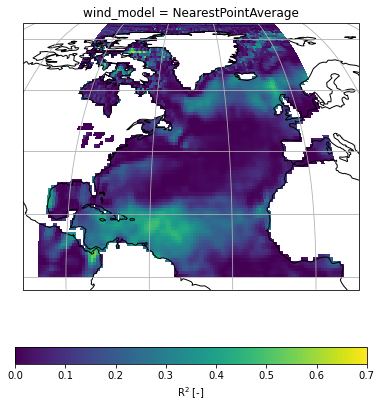

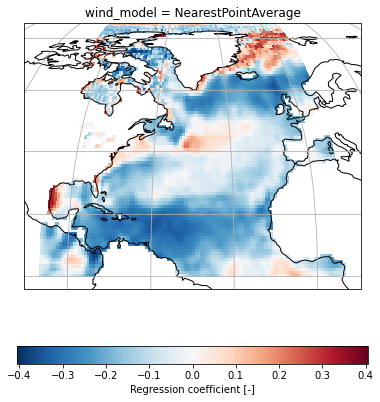

In [160]:
plt.figure(figsize = (7,7))
ax = plt.axes(projection=ccrs.Robinson(central_longitude=-45))
ax.coastlines()
ax.gridlines()
results_hadisst.r2.sel(wind_model = wind_models[0]).plot(ax=ax, transform=ccrs.PlateCarree(), vmin = 0.0, vmax = 0.7,
                                                        cbar_kwargs = {'orientation':'horizontal', 'shrink':0.9, 'label':'R$^2$ [-]'})

plt.savefig('/Users/iriskeizer/Documents/Wind effect/Figures/SST/NP_hadisst_r2', bbox_inches='tight', dpi = 500)

plt.figure(figsize = (7,7))
ax = plt.axes(projection=ccrs.Robinson(central_longitude=-45))
ax.coastlines()
ax.gridlines()
results_hadisst.reg_coef.sel(wind_model = wind_models[0]).plot(ax=ax, transform=ccrs.PlateCarree(),
                                                        cbar_kwargs = {'orientation':'horizontal', 'shrink':0.9, 'label':'Regression coefficient [-]'})
plt.savefig('/Users/iriskeizer/Documents/Wind effect/Figures/SST/NP_hadisst_regcoef', bbox_inches='tight', dpi = 500)



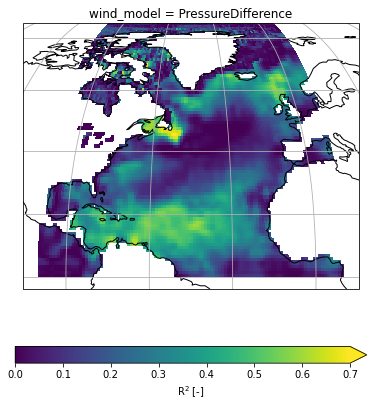

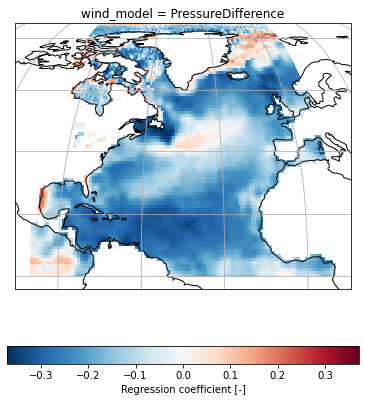

In [161]:
plt.figure(figsize = (7,7))
ax = plt.axes(projection=ccrs.Robinson(central_longitude=-45))
ax.coastlines()
ax.gridlines()
results_hadisst.r2.sel(wind_model = wind_models[1]).plot(ax=ax, transform=ccrs.PlateCarree(), vmin = 0.0, vmax = 0.7,
                                                        cbar_kwargs = {'orientation':'horizontal', 'shrink':0.9, 'label':'R$^2$ [-]'})
plt.savefig('/Users/iriskeizer/Documents/Wind effect/Figures/SST/PD_hadisst_r2', bbox_inches='tight', dpi = 500)


plt.figure(figsize = (7,7))
ax = plt.axes(projection=ccrs.Robinson(central_longitude=-45))
ax.coastlines()
ax.gridlines()
results_hadisst.reg_coef.sel(wind_model = wind_models[1]).plot(ax=ax, transform=ccrs.PlateCarree(),
                                                        cbar_kwargs = {'orientation':'horizontal', 'shrink':0.9, 'label':'Regression coefficient [-]'})
plt.savefig('/Users/iriskeizer/Documents/Wind effect/Figures/SST/PD_hadisst_regcoef', bbox_inches='tight', dpi = 500)



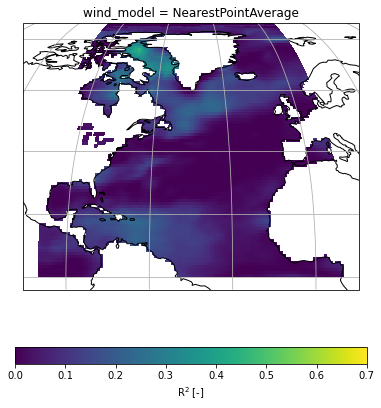

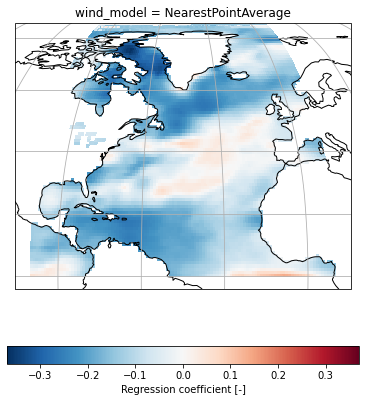

In [162]:
plt.figure(figsize = (7,7))
ax = plt.axes(projection=ccrs.Robinson(central_longitude=-45))
ax.coastlines()
ax.gridlines()
results_cobesst.r2.sel(wind_model = wind_models[0]).plot(ax=ax, transform=ccrs.PlateCarree(), vmin = 0.0, vmax = 0.7,
                                                        cbar_kwargs = {'orientation':'horizontal', 'shrink':0.9, 'label':'R$^2$ [-]'})
plt.savefig('/Users/iriskeizer/Documents/Wind effect/Figures/SST/NP_cobesst_r2', bbox_inches='tight', dpi = 500)


plt.figure(figsize = (7,7))
ax = plt.axes(projection=ccrs.Robinson(central_longitude=-45))
ax.coastlines()
ax.gridlines()
results_cobesst.reg_coef.sel(wind_model = wind_models[0]).plot(ax=ax, transform=ccrs.PlateCarree(),
                                                        cbar_kwargs = {'orientation':'horizontal', 'shrink':0.9, 'label':'Regression coefficient [-]'})
plt.savefig('/Users/iriskeizer/Documents/Wind effect/Figures/SST/NP_cobesst_regcoef', bbox_inches='tight', dpi = 500)



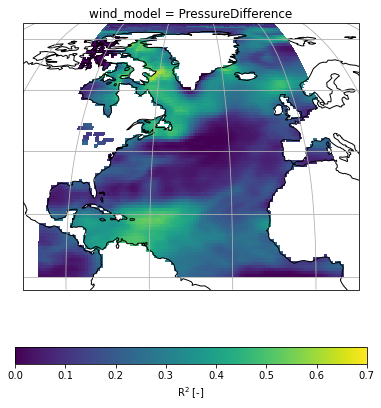

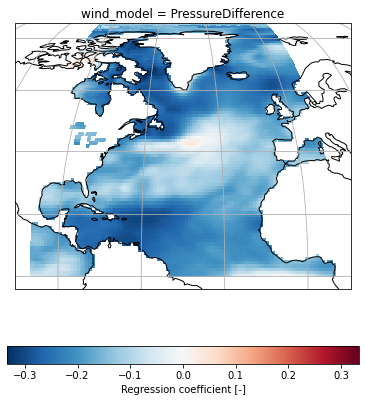

In [163]:
plt.figure(figsize = (7,7))
ax = plt.axes(projection=ccrs.Robinson(central_longitude=-45))
ax.coastlines()
ax.gridlines()
results_cobesst.r2.sel(wind_model = wind_models[1]).plot(ax=ax, transform=ccrs.PlateCarree(), vmin = 0.0, vmax = 0.7,
                                                        cbar_kwargs = {'orientation':'horizontal', 'shrink':0.9, 'label':'R$^2$ [-]'})
plt.savefig('/Users/iriskeizer/Documents/Wind effect/Figures/SST/PD_cobesst_r2', bbox_inches='tight', dpi = 500)


plt.figure(figsize = (7,7))
ax = plt.axes(projection=ccrs.Robinson(central_longitude=-45))
ax.coastlines()
ax.gridlines()
results_cobesst.reg_coef.sel(wind_model = wind_models[1]).plot(ax=ax, transform=ccrs.PlateCarree(),
                                                        cbar_kwargs = {'orientation':'horizontal', 'shrink':0.9, 'label':'Regression coefficient [-]'})
plt.savefig('/Users/iriskeizer/Documents/Wind effect/Figures/SST/PD_cobesst_regcoef', bbox_inches='tight', dpi = 500)

